In [1]:
import pandas as pd

In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
def read_test_data():
    Dfs = []
    test_df = []
    coords = pd.read_csv("./coords.csv", header=None)
    for name in ["mslp", "sst", "ssta", "t2m"]:
        df = pd.read_csv(f"./test_input_{name}_phase_two.csv", header=None)
        print("Shape df", df.shape)
        Dfs.append(df)
        #Dfs.append(df.T.reset_index(drop=True))
    j = 0
    for i in range(0, df.shape[0], 12):
        feat = pd.concat([coords, Dfs[0].iloc[i:i+12], Dfs[1].iloc[i:i+12], Dfs[2].iloc[i:i+12], Dfs[3].iloc[i:i+12]], axis=0).reset_index(drop=True)
        feat = feat.T.reset_index(drop=True)
        feat.columns = [f"feat_{k}" for k in range(feat.shape[1])]
        if j < 3:
            print(feat.columns)
        test_df.append(feat)
        j += 1
    test_df = pd.concat(test_df, axis=0)
    return test_df

In [4]:
test_data = read_test_data()

Shape df (852, 5774)
Shape df (852, 5774)
Shape df (852, 5774)
Shape df (852, 5774)
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49'],
      dtype='object')
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24

In [5]:
test_data.shape

(409954, 50)

In [6]:
monthly_stats = np.load("monthly_stats.npy")

In [7]:
monthly_stats = np.tile(monthly_stats,(len(test_data)//5774,1))

In [8]:
monthly_stats_df = pd.DataFrame(monthly_stats, columns=[f"add_feat_{i}" for i in range(24)])

In [9]:
data_rich = pd.concat([test_data.reset_index(drop=True), monthly_stats_df], axis=1)

In [10]:
import joblib

In [11]:
#lgb_model = joblib.load("./trained_models/lgb_model.joblib")
#catb_model = joblib.load("./trained_models/catb_model.joblib")

In [12]:
#y_pred1 = lgb_model.predict(test_data.values)
#y_pred2 = catb_model.predict(test_data.values)

In [13]:
#y_pred = 0.2*y_pred1 + 0.8*y_pred2 ==> -0.06
#y_pred = 0.55*y_pred1 + 0.45*y_pred2 ==> -0.03
#y_pred = 0.8*y_pred1 + 0.2*y_pred2 ==> -0.01
#y_pred = 0.95*y_pred1 + 0.05*y_pred2 ==> -0.0012
#y_pred = 0.99*y_pred1 - 0.01*y_pred2 ==> 0.0032

In [14]:
#y_pred = 0.99*y_pred1 - 0.01*y_pred2

In [15]:
#pred_df = pd.DataFrame(y_pred.reshape(71, 5774))

In [16]:
#pred_df

In [17]:
#pred_df.to_csv("./predictions.csv", index=False, header=False)

## K-Fold Predictions

In [18]:
import os
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler

In [19]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, coeffs):
        super().__init__()
        self.estimators = estimators
        self.coeffs = coeffs
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [coeff*estimator.predict(X) for estimator, coeff in zip(self.estimators, self.coeffs)]
        return np.sum(y_preds, axis=0)

In [20]:
def load_boosting_models(path, num_folds=5):
    Models = []
    for fold in range(num_folds):
        for model_name in ["catb", "lgb"]:
            for trained_model_path in os.listdir(path):
                if trained_model_path.startswith("."): continue
                if model_name in trained_model_path and f'fold{fold}' in trained_model_path:
                    model = joblib.load(f'{path}/{trained_model_path}')
                    Models.append(model)
    return Models

In [21]:
def load_xgb_models(path, num_folds=5):
    Models = []
    for fold in range(num_folds):
        for model_name in ["xgb"]:
            for trained_model_path in os.listdir(path):
                if trained_model_path.startswith("."): continue
                if model_name in trained_model_path and f'fold{fold}' in trained_model_path:
                    model = joblib.load(f'{path}/{trained_model_path}')
                    Models.append(model)
    return Models

In [22]:
boosting_models = load_boosting_models("./kfold_trained2/", 5)
coeffs = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
boosting_models = VotingModel(boosting_models, coeffs)

In [23]:
add_feat_boosting_models = VotingModel(load_boosting_models("./trained3/"), coeffs)

In [24]:
#scaler = joblib.load("./kfold_trained_preproc/Scaler.joblib")

In [25]:
from pytorch_implementation.dataset import Dataset
from pytorch_implementation.helper_funcs import *

In [26]:
trained_nn_models = load_trained("./trained_nn2")

In [27]:
#len(trained_nn_models)

In [28]:
#y_pred_xgb = xgb_models.predict(test_data.values)

In [29]:
y_pred_boost = boosting_models.predict(test_data.values)
y_pred_add_feat = add_feat_boosting_models.predict(data_rich.values)

In [30]:
y_pred_gru = average_prediction(data_rich.values, trained_nn_models[0::2])
y_pred_lstm = average_prediction(data_rich.values, trained_nn_models[1::2])

In [31]:
y_pred_add_feat

array([0.61116527, 0.68589223, 0.77799378, ..., 0.44565305, 0.56571334,
       0.01403037])

In [32]:
y_pred_lstm

array([[ 0.29353178],
       [ 0.48458928],
       [ 0.5797032 ],
       ...,
       [ 0.33627453],
       [ 0.40764788],
       [-0.30430657]], dtype=float32)

In [33]:
y_pred_gru

array([[-0.19206609],
       [ 0.18848656],
       [ 0.268022  ],
       ...,
       [ 0.08313328],
       [ 0.19820952],
       [-0.7608103 ]], dtype=float32)

In [34]:
y_pred_boost

array([ 0.62825785,  0.72681577,  0.80259033, ...,  0.48733601,
        0.57806176, -0.06142738])

In [35]:
#y_pred = 0.15*y_pred_preproc + 0.85*(0.9*y_pred_boost + 0.03*y_pred_gru.squeeze() + 0.07*y_pred_lstm.squeeze())
y_pred = 0.29*y_pred_add_feat + 0.925*(0.92*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.10*y_pred_lstm.squeeze())

In [36]:
pred_df = pd.DataFrame(y_pred.reshape(71, 5774))

In [37]:
pred_df

,0,1,2,3,4,5,6,7,8,9,...,5764,5765,5766,5767,5768,5769,5770,5771,5772,5773
0,0.737260,0.863997,0.964724,0.822459,0.502867,0.335265,0.312970,0.309267,0.288148,0.256314,...,0.108791,0.093219,0.391264,0.609180,0.632626,0.730513,0.765299,0.628349,0.632512,0.048772
1,0.305259,0.489303,0.233372,0.130508,0.023693,0.053169,0.058463,0.093675,0.098244,0.094900,...,-0.098097,-0.179598,-0.000147,0.034844,-0.001426,-0.103879,0.283505,0.066084,0.595478,0.700236
2,-0.002011,-0.225967,-0.206568,-0.299413,-0.255341,-0.187056,-0.186493,-0.155472,-0.146109,-0.164135,...,0.339184,0.308925,0.433924,0.477538,0.343133,0.396715,0.275597,0.372756,0.593592,0.708516
3,-0.186681,-0.300823,-0.285377,-0.282432,-0.266876,-0.130679,-0.102840,-0.126579,-0.162842,-0.159461,...,0.109885,0.077354,0.241673,0.296505,0.219116,0.178313,0.158589,0.021225,-0.011373,-0.063938
4,0.175920,0.185588,0.252664,0.183452,0.131811,0.082573,0.060237,0.106812,0.078194,0.023037,...,-0.061947,-0.090067,0.127181,0.143733,0.119721,0.105284,0.473072,0.361502,0.782993,0.677929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.565353,0.492856,0.414461,0.365064,0.305825,0.213332,0.180546,0.205435,0.161497,0.137071,...,0.718727,0.812269,0.708011,0.667998,0.534044,0.580951,0.697365,0.692561,0.676797,0.557876
67,0.342529,0.324246,0.201195,0.137605,0.081928,0.067512,0.058088,0.110826,0.105881,0.036824,...,-0.245737,-0.250397,0.030592,0.000838,-0.009893,-0.006614,0.286883,-0.014042,0.450207,0.657166
68,0.115459,0.157139,0.142037,0.053140,0.028410,0.008984,-0.010843,0.075242,0.072787,0.020367,...,0.060899,0.053850,0.374894,0.335693,0.154732,0.128242,0.313093,0.160542,0.492169,0.830876
69,-0.106175,-0.368422,-0.305821,-0.504577,-0.440155,-0.427806,-0.509078,-0.432523,-0.545671,-0.595333,...,0.125303,0.122583,0.357381,0.423291,0.362262,0.436394,0.473641,0.359863,0.504130,0.026761


In [38]:
pred_df.to_csv("./predictions_phase_two.csv", index=False, header=False)

In [39]:
target = pd.read_csv("target/data_test_output/test_output_phase_two.csv", header=None)

In [40]:
import matplotlib.pyplot as plt

In [41]:
cols = [0, 1003, 273]

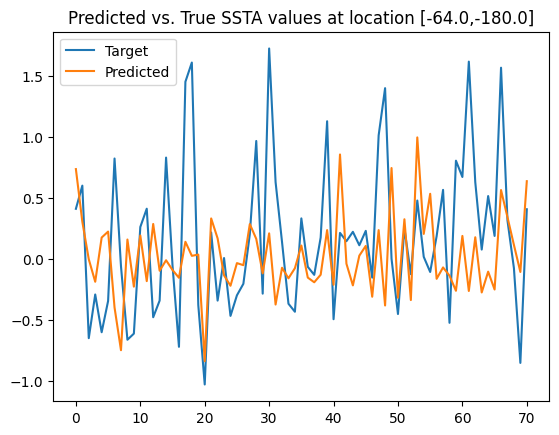

In [50]:
plt.plot(target[cols[0]])
plt.plot(pred_df[cols[0]])

plt.legend([f"Target", f"Predicted"])
plt.title("Predicted vs. True SSTA values at location [-64.0,-180.0]")
plt.savefig("test-phase.pdf", bbox_inches='tight')
plt.show()

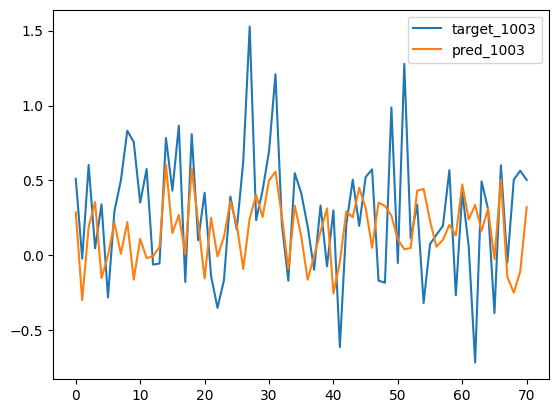

In [43]:
plt.plot(target[cols[1]])
plt.plot(pred_df[cols[1]])

plt.legend([f"target_{cols[1]}", f"pred_{cols[1]}"])
plt.show()

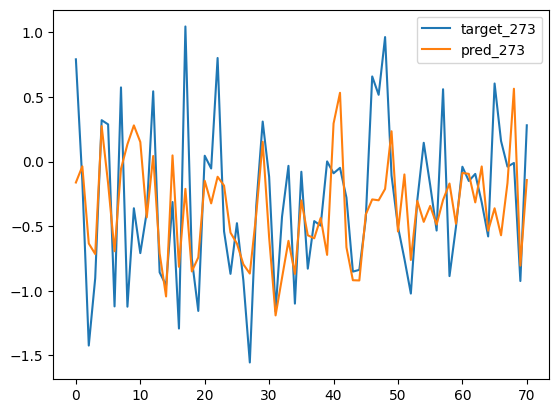

In [44]:
plt.plot(target[cols[2]])
plt.plot(pred_df[cols[2]])

plt.legend([f"target_{cols[2]}", f"pred_{cols[2]}"])
plt.show()

In [45]:
from starting_kit_phase_one.evaluation import evaluate

In [46]:
print("Phase One...")
test_y_file = './target/data_test_output/test_output_phase_one.csv'
baseline_file = './starting_kit_phase_one/out/test_output_pred_persist_phase_one.csv'
prediction_file = './predictions_phase_one.csv'
evaluate(test_y_file, baseline_file, prediction_file)
print("\n\n")
print("Phase Two")
test_y_file = './target/data_test_output/test_output_phase_two.csv'
baseline_file = './test_output_pred_persist_phase_two.csv'
prediction_file = './predictions_phase_two.csv'
evaluate(test_y_file, baseline_file, prediction_file)

Phase One...
Average RMSE (Baseline): 0.649344200427837
Average RMSE (Model): 0.5502102328489467
Final Result (Baseline RMSE - Model RMSE): 0.09913396757889037



Phase Two
Average RMSE (Baseline): 0.6561923737328125
Average RMSE (Model): 0.5689849078876463
Final Result (Baseline RMSE - Model RMSE): 0.08720746584516614


0.08720746584516614

In [47]:
# KFold

# catb 500 estimators, lgbm 1000 estimators
# [0.05, 0.15, 0.05, 0.15, 0.05, 0.15, 0.05, 0.15, 0.05, 0.15] ==> 0.093

# catb and lgb 1000 estimators
# [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] ==> 0.094

# catb and lgb 1000 estimators
# ([0.08, 0.12, 0.08, 0.12, 0.1, 0.1, 0.1, 0.1, 0.06, 0.14])*0.91 + 0.01*gru + 0.09*lstm ==> 0.0951
# y_pred = 0.25*y_pred_add_feat + 0.90*(0.91*y_pred_boost + 0.02*y_pred_gru.squeeze() + 0.10*y_pred_lstm.squeeze()) ==> 0.0985
# y_pred = 0.28*y_pred_add_feat + 0.95*(0.92*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.09*y_pred_lstm.squeeze()) ==> 0.09862
# linear comb catb lgb and newly trained gru + lstm: y_pred = 0.28*y_pred_add_feat + 0.95*(0.92*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.09*y_pred_lstm.squeeze()) ==> 0.0989
# linear catb and lgb + newly trained lstm and gru: y_pred = 0.28*y_pred_add_feat + 0.94*(0.92*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.10*y_pred_lstm.squeeze()) ==> 0.0991
# even better: y_pred = 0.28*y_pred_add_feat + 0.92*(0.92*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.10*y_pred_lstm.squeeze()) ==> 0.09913